In [1]:
# Imports

import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,os,itertools,datetime,time,sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split

import networkx as nx

sns.set()

In [2]:
# Load data

rootpath = './../../../../../../../Dropbox/TF_data/'
df0 = pd.read_csv(rootpath+'TURING/tweets.csv',encoding='latin-1',header=None)

df0.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Unified naming and remove duplicates

df = df0.drop(columns=[0,1,3]).rename(columns={
    2:'Timestamp',
    4:'Account',
    5:'Text'
})

df = df.drop_duplicates()

In [94]:
# Determine user mentions in tweets

df['Text'] = df['Text'].apply(lambda x: x.replace('...',' ').replace('\'','').replace('-',' ').replace('  ',' ').replace('   ',' '))
df['User References'] = df['Text'].apply(lambda x: [k for k in x.split(' ') if k.startswith('@')])

L = []

for k in df['User References']:
    L += k

L = list(set(L))

In [73]:
# Build user encoding dictionary

user_dict_dec = dict(enumerate(df['Account'].unique()))
user_dict_enc = {v:k for k,v in user_dict_dec.items()}

In [74]:
# Extend user dictionary by tweeting users

c_max_key = max(user_dict_dec.keys())

for u in L:
    if u not in user_dict_enc.keys():
        user_dict_enc[u] = c_max_key
        c_max_key += 1

In [75]:
# Also extend decoding dict to incorporate tweeting users

user_dict_dec = {v:k for k,v in user_dict_enc.items()}

In [76]:
# Encode users

df['AccountID'] = df['Account'].apply(lambda x: user_dict_enc[x])
df['User Reference IDs'] = df['User References'].apply(lambda x: [user_dict_enc[k] for k in x])

In [77]:
df.head()

,Timestamp,Account,Text,User References,AccountID,User Reference IDs
0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpiccom/2y1zl Awww, tha...",[@switchfoot],0,[899456]
1,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his Facebook by t...,[],1,[]
2,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball Mana...,[@Kenichan],2,[876475]
3,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,[],3,[]
4,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, its not behaving at all i...",[@nationwideclass],4,[1014053]


In [78]:
# Determine user-user relations

t0 = df[['AccountID','User Reference IDs']]
t0.head()

,AccountID,User Reference IDs
0,0,[899456]
1,1,[]
2,2,[876475]
3,3,[]
4,4,[1014053]


In [79]:
# Expand reference user list for each row

t1 = pd.DataFrame(
    {col:np.repeat(t0[col].values, t0['User Reference IDs'].str.len()) for col in t0.columns.difference(['User Reference IDs'])}
).assign(**{'User Reference IDs':np.concatenate(t0['User Reference IDs'].values)})[t0.columns.tolist()]

t1['User Reference IDs'] = t1['User Reference IDs'].astype(int)

In [80]:
# Remove duplicates

t1 = t1.drop_duplicates()
t1.head()

,AccountID,User Reference IDs
0,0,899456
1,2,876475
2,4,1014053
3,5,742268
4,7,974749


In [81]:
# Create complete table of user-user relations by attaching inverted table to itself and removing duplicates

t2 = pd.concat([t1,t1.rename(columns={'AccountID':'User Reference IDs','User Reference IDs':'AccountID'})]).drop_duplicates()

In [82]:
# Count relations per user to identify power users

t3 = t2.groupby(['AccountID']).count().reset_index(drop=False).rename(columns={
    'User Reference IDs':'Power'
}).sort_values(by='Power',ascending=False)
t3.head()

,AccountID,Power
644466,1000178,9314
471393,827105,3379
394124,749836,2665
395195,750907,2171
311206,666918,1083


In [83]:
# Attach relations count to relations table 

t2 = t2.merge(t3,on='AccountID',how='left')
t2.head()

,AccountID,User Reference IDs,Power
0,0,899456,2
1,2,876475,7
2,4,1014053,34
3,5,742268,1
4,7,974749,23


In [84]:
# Extract egde list of connected users

edge_list = t2[['AccountID','User Reference IDs']].values.tolist()

In [85]:
# Generate graph

G = nx.Graph()
G.add_edges_from(edge_list)

In [86]:
# Determine list of connected sub-graphs

subG_gen = nx.algorithms.connected_components(G)
subG = list(subG_gen)

In [98]:
# Determine sub-graphs with length exceeding 25

[(k,len(subG[k])) for k in range(len(subG)) if len(subG[k])>25]

[(0, 355389),
 (1285, 28),
 (4380, 34),
 (7517, 27),
 (11331, 34),
 (18353, 26),
 (79579, 35),
 (126343, 36)]

In [104]:
t2[t2['AccountID'].isin(subG[7517])]

,AccountID,User Reference IDs,Power
27175,63156,963643,12
54656,63156,843323,12
86002,63156,811483,12
99613,185740,792013,3
106367,185740,1003748,3
150049,104824,761130,3
158712,63156,779295,12
175180,63156,672813,12
184798,169660,690857,2
185217,169660,926803,2


In [105]:
edgelist_tmp = t2[t2['AccountID'].isin(subG[7517])][['AccountID','User Reference IDs']].values.tolist()

In [106]:
G_tmp = nx.DiGraph()
G_tmp.add_edges_from(edgelist_tmp)

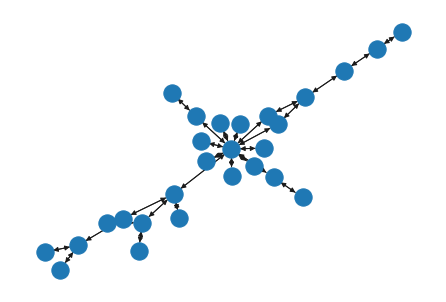

In [107]:
nx.draw(G_tmp)

In [109]:
t3 = df[df['AccountID'].isin(subG[7517])]

In [111]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2 MB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 8.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
